# VGG fine tuning from pre-trained Slim model

[VGGNet](https://arxiv.org/pdf/1409.1556.pdf) to classify flowers into the 17 categories of the Oxford Flowers data set.

This implementation uses a pretrained VGG16 model from TF-Slim. See https://github.com/tensorflow/models/tree/master/research/slim.

Installed with python setup.py install from models/research/slim

## Preliminary steps

### Global params

In [1]:
epochs = 1
batch_size = 32
test_size = 0.1
pool_size = 2
n_maxpool_layers = 5
padding = 'VALID'
dropout = 0.5
display_steps = 2
learning_rate = 1e-4

### Set seed

In [2]:
import numpy as np
np.random.seed(42)

### Load dependencies

In [3]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
import math

### Load the data

In [4]:
import tflearn.datasets.oxflower17 as oxflower17
X, Y = oxflower17.load_data(one_hot=True)

curses is not supported on this machine (please install/reinstall curses for an optimal experience)


In [5]:
num_examples, img_height, img_width, img_channels = X.shape

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=test_size, random_state=42)

In [6]:
print("Shape of training set {}".format(X_train.shape))

Shape of training set (1224, 224, 224, 3)


In [7]:
print("Shape of labels {}".format(Y_train.shape))

Shape of labels (1224, 17)


In [8]:
num_classes = Y.shape[1]
print(num_classes)

17


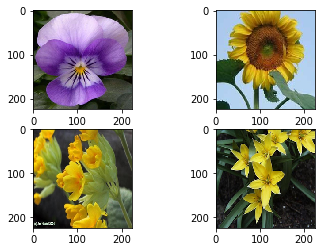

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
fig, axes = plt.subplots(2,2)
axes[0,0].imshow(X_train[0])
axes[0,1].imshow(X_train[1])
axes[1,0].imshow(X_train[2])
axes[1,1].imshow(X_train[3])

In [10]:
print(Y_train[0:4])

[[ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]]


## Define the network architecture

### Network

#### Load the VGG-16 checkpoint

In [11]:
from datasets import dataset_utils
import tensorflow as tf

url = "http://download.tensorflow.org/models/vgg_16_2016_08_28.tar.gz"
checkpoints_dir = 'checkpoints'

if not tf.gfile.Exists(checkpoints_dir):
    tf.gfile.MakeDirs(checkpoints_dir)
    dataset_utils.download_and_uncompress_tarball(url, checkpoints_dir)

## Run the architecture

### Build the model

In [12]:
import tensorflow.contrib.slim as slim
from nets import vgg

def model_fn(features, labels, mode, params):
    """Model function for Estimator."""

    # TODO: add tensorboard
    
    output, _ = vgg.vgg_16(features["x"], num_classes = num_classes,
                           is_training = (mode == tf.estimator.ModeKeys.TRAIN) or
                                        (mode == tf.estimator.EVAL),
                           dropout_keep_prob = 1.0 - dropout, fc_conv_padding=padding)

    predictions = tf.argmax(output, 1)

    # Provide an estimator spec for `ModeKeys.PREDICT`.
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(
            mode=mode,
            predictions={"classes": predictions})

    # Calculate loss using cross entropy
    loss = tf.losses.softmax_cross_entropy(labels, output)
    tf.summary.scalar('loss', loss)

    # Calculate accuracy as additional eval metric
    eval_metric_ops = {
        "accuracy": tf.metrics.accuracy(tf.argmax(labels, 1), predictions)
    }

    # TODO: add accuracy to tensorboard summary
    
    optimizer = tf.train.AdamOptimizer(
        learning_rate=params["learning_rate"])
    train_op = optimizer.minimize(loss)

    # Provide an estimator spec for `ModeKeys.EVAL` and `ModeKeys.TRAIN` modes.
    return tf.estimator.EstimatorSpec(
        mode=mode,
        loss=loss,
        train_op=train_op,
        eval_metric_ops=eval_metric_ops)

### Trainining

In [ ]:
import os

def get_init_fn():
    """Returns a function run by the chief worker to warm-start the training."""
    checkpoint_exclude_scopes=["vgg_16/fc6", "vgg_16/fc7", "vgg_16/fc8"]
    
    exclusions = [scope.strip() for scope in checkpoint_exclude_scopes]

    variables_to_restore = []
    for var in slim.get_model_variables("vgg_16"):
        excluded = False
        for exclusion in exclusions:
            if var.op.name.startswith(exclusion):
                excluded = True
                break
        if not excluded:
            variables_to_restore.append(var)

    return slim.assign_from_checkpoint_fn(
      os.path.join(checkpoints_dir, 'vgg_16.ckpt'),
      variables_to_restore)

In [ ]:
train_dir = 'vgg16_finetuned/'

with tf.Graph().as_default():
    tf.logging.set_verbosity(tf.logging.INFO)
    
    images, one_hot_labels = tf.train.shuffle_batch([X_train, Y_train], batch_size,
                                                    enqueue_many=True,
                                                    capacity=64, min_after_dequeue=32,
                                                    allow_smaller_final_batch=True)

    # Create the model, use the default arg scope to configure the batch norm parameters.
    with slim.arg_scope(vgg.vgg_arg_scope()):
        logits, _ = vgg.vgg_16(images, num_classes=num_classes, is_training=True,
                               dropout_keep_prob = 1.0 - dropout, fc_conv_padding=padding)
        
    # Specify the loss function:
    loss = tf.losses.softmax_cross_entropy(one_hot_labels, logits)

    # Create some summaries to visualize the training process:
    tf.summary.scalar('losses/Total_Loss', loss)
  
    # Specify the optimizer and create the train op:
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(loss)
    
    # Run the training:
    final_loss = slim.learning.train(
        train_op,
        logdir=train_dir,
        init_fn=get_init_fn(),
        number_of_steps=1)
        
print('Finished training. Last batch loss %f' % final_loss)

INFO:tensorflow:Restoring parameters from checkpoints\vgg_16.ckpt
INFO:tensorflow:Starting Session.
INFO:tensorflow:Saving checkpoint to path vgg16_finetuned/model.ckpt
INFO:tensorflow:Starting Queues.
INFO:tensorflow:global_step/sec: 0
